# Paddy Yield Classification Project
## End-to-End Machine Learning Workflow for Predicting Rice Yield Categories

Bu notebook, pirinç verim kategorilerini tahmin etmek için kapsamlı bir makine öğrenmesi iş akışı içermektedir.

**İçerik:**
1. Data Loading and Exploration
2. Classification Target Construction
3. Data Preprocessing
4. Model Training and Comparison
5. Hyperparameter Optimization
6. Test Set Evaluation
7. Visualizations and Analysis

## 1. Importing Libraries

In [2]:
# Temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn kütüphaneleri
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Metrikler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve,
    auc, ConfusionMatrixDisplay, precision_score, recall_score
)

# Uyarıları kapat
import warnings
warnings.filterwarnings('ignore')



# Rastgelelik için seed ayarla
np.random.seed(42)

print("Tüm kütüphaneler başarıyla yüklendi")


Tüm kütüphaneler başarıyla yüklendi


## 2. Data Loading and Initial Exploration
Veri setimizi yükleyip temel özelliklerini inceleyelim.

In [3]:
print("VERİ YÜKLEME VE ANLAMA KISMI")

# Veri setini yükle
df = pd.read_csv('paddydataset.csv')

print(f"\nVeri Seti Boyutu: {df.shape}")
print(f"Örnek Sayısı: {df.shape[0]}")
print(f"Özellik Sayısı: {df.shape[1] - 1}")

print("\nİlk 5 satır:")
display(df.head())

print("\nVeri Tipleri Özeti:")
print(df.dtypes.value_counts())

print("\nEksik Değerler:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("Veri setinde eksik değer bulunmamaktadır.")
else:
    print(missing[missing > 0])

print("\nHedef Değişken (Paddy yield) İstatistikleri:")
print(df['Paddy yield(in Kg)'].describe())

VERİ YÜKLEME VE ANLAMA KISMI

Veri Seti Boyutu: (2789, 45)
Örnek Sayısı: 2789
Özellik Sayısı: 44

İlk 5 satır:


,Hectares,Agriblock,Variety,Soil Types,Seedrate(in Kg),LP_Mainfield(in Tonnes),Nursery,Nursery area (Cents),LP_nurseryarea(in Tonnes),DAP_20days,...,Wind Direction_D1_D30,Wind Direction_D31_D60,Wind Direction_D61_D90,Wind Direction_D91_D120,Relative Humidity_D1_D30,Relative Humidity_D31_D60,Relative Humidity_D61_D90,Relative Humidity_D91_D120,Trash(in bundles),Paddy yield(in Kg)
0,6,Cuddalore,CO_43,alluvial,150,75.0,dry,120,6,240,...,SW,W,NNW,WSW,72.0,78,88,85,540,35028
1,6,Kurinjipadi,ponmani,clay,150,75.0,wet,120,6,240,...,NW,S,SE,SSE,64.6,85,84,87,600,35412
2,6,Panruti,delux ponni,alluvial,150,75.0,dry,120,6,240,...,ENE,NE,NNE,W,85.0,96,84,79,600,36300
3,6,Kallakurichi,CO_43,clay,150,75.0,wet,120,6,240,...,W,WNW,SE,S,88.5,95,81,84,540,35016
4,6,Sankarapuram,ponmani,alluvial,150,75.0,dry,120,6,240,...,SSE,W,SW,NW,72.7,91,83,81,600,34044



Veri Tipleri Özeti:
int64      19
float64    18
object      8
Name: count, dtype: int64

Eksik Değerler:
Veri setinde eksik değer bulunmamaktadır.

Hedef Değişken (Paddy yield) İstatistikleri:
count     2789.000000
mean     22517.728935
std       9199.661393
min       5410.000000
25%      16389.000000
50%      24636.000000
75%      31035.000000
max      38814.000000
Name: Paddy yield(in Kg), dtype: float64


## 3. Classification Target Construction

Verim değerlerini üç kategoriye ayırıyoruz:
- **Düşük Verim**: Alt %33 (< 33. persentil)
- **Orta Verim**: Orta %34 (33-67. persentil)
- **Yüksek Verim**: Üst %33 (> 67. persentil)

In [4]:
print("SINIFLANDIRMA HEDEFİ")

# Verim kategorileri yüzdelik (quantile) temelli olarak belirlenmiştir.
# %33 ve %67 yüzdelik değerleri kullanılarak Düşük, Orta ve Yüksek verim sınıfları oluşturulmuştur.
# Bu yaklaşım sınıfların yaklaşık olarak dengeli olmasını sağlar ve sınıf dengesizliğini azaltır.
q33 = df['Paddy yield(in Kg)'].quantile(0.33)
q67 = df['Paddy yield(in Kg)'].quantile(0.67)

print(f"\nVerim Kategorileri:")
print(f"  Düşük Verim: < {q33:.2f} Kg (Alt %33)")
print(f"  Orta Verim: {q33:.2f} - {q67:.2f} Kg (Orta %34)")
print(f"  Yüksek Verim: > {q67:.2f} Kg (Üst %33)")

def categorize_yield(yield_value):
    if yield_value < q33:
        return 'Low'
    elif yield_value < q67:
        return 'Medium'
    else:
        return 'High'

df['Yield_Category'] = df['Paddy yield(in Kg)'].apply(categorize_yield)

print("\nSınıf Dağılımı:")
print(df['Yield_Category'].value_counts().sort_index())

print("\nSınıf Oranları:")
print(df['Yield_Category'].value_counts(normalize=True).sort_index())

SINIFLANDIRMA HEDEFİ

Verim Kategorileri:
  Düşük Verim: < 17508.00 Kg (Alt %33)
  Orta Verim: 17508.00 - 30355.00 Kg (Orta %34)
  Yüksek Verim: > 30355.00 Kg (Üst %33)

Sınıf Dağılımı:
Yield_Category
High       923
Low        865
Medium    1001
Name: count, dtype: int64

Sınıf Oranları:
Yield_Category
High      0.330943
Low       0.310147
Medium    0.358910
Name: proportion, dtype: float64


## 4. Data preprocessing

### 4.1 Feature and Target Separation

In [5]:
print("DATA  PREPROCESSING")


# Özellikleri ve hedefi ayır
X = df.drop(['Paddy yield(in Kg)', 'Yield_Category'], axis=1)
y = df['Yield_Category']

print(f"\nÖzellik Matrisi Boyutu: {X.shape}")
print(f"Hedef Vektör Boyutu: {y.shape}")

# Kategorik ve sayısal sütunları belirle
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nKategorik Özellikler ({len(categorical_cols)}): {categorical_cols}")
print(f"Sayısal Özellikler: {len(numerical_cols)} adet")

DATA  PREPROCESSING

Özellik Matrisi Boyutu: (2789, 44)
Hedef Vektör Boyutu: (2789,)

Kategorik Özellikler (8): ['Agriblock', 'Variety', 'Soil Types', 'Nursery', 'Wind Direction_D1_D30', 'Wind Direction_D31_D60', 'Wind Direction_D61_D90', 'Wind Direction_D91_D120']
Sayısal Özellikler: 36 adet


### 4.2 Encoding Categorical Variables

In [6]:
print("\nCategorical Variables Kodlanması:")
print("-"*60)

label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    print(f"  {col}: {X[col].nunique()} benzersiz değer")
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print("\nCategorical Variables başarıyla kodlandı!")


Categorical Variables Kodlanması:
------------------------------------------------------------
  Agriblock: 6 benzersiz değer
  Variety: 3 benzersiz değer
  Soil Types: 2 benzersiz değer
  Nursery: 2 benzersiz değer
  Wind Direction_D1_D30: 6 benzersiz değer
  Wind Direction_D31_D60: 5 benzersiz değer
  Wind Direction_D61_D90: 5 benzersiz değer
  Wind Direction_D91_D120: 6 benzersiz değer

Categorical Variables başarıyla kodlandı!


### 4.3 Outlier Detection

In [7]:
print("\nOutliers Tespiti (3 standart sapma ötesi):")
print("-"*60)

outliers_found = False
for col in numerical_cols:
    mean = X_encoded[col].mean()
    std = X_encoded[col].std()
    outliers = X_encoded[(X_encoded[col] < mean - 3*std) | (X_encoded[col] > mean + 3*std)][col]
    if len(outliers) > 0:
        print(f"  {col}: {len(outliers)} aykırı değer tespit edildi")
        outliers_found = True

if not outliers_found:
    print("Önemli outliers  tespit edilmedi")


Outliers Tespiti (3 standart sapma ötesi):
------------------------------------------------------------
Önemli outliers  tespit edilmedi


### 4.4 Class Imbalance Analysis

In [8]:
print("\nClass Imbalance Analysis:")
print("-"*60)

class_counts = y.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"  Dengesizlik Oranı: {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("Önemli sınıf dengesizliği tespit edildi!")
else:
    print("Sınıflar nispeten dengeli")


Class Imbalance Analysis:
------------------------------------------------------------
  Dengesizlik Oranı: 1.16
Sınıflar nispeten dengeli


## 5. Data Splitting and Scaling

Veriyi üç parçaya bölüyoruz:
- **Eğitim Seti**: %64 (model eğitimi için)
- **Doğrulama Seti**: %16 (model seçimi için)
- **Test Seti**: %20 (final değerlendirme için)

In [9]:
print("="*80)
print("Data Splitting and Scaling")
print("="*80)

# İlk bölme: test setini ayır (%20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# İkinci bölme: eğitim ve doğrulama setlerini ayır (%64 eğitim, %16 doğrulama)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"\nEğitim seti: {X_train.shape[0]} örnek ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Doğrulama seti: {X_val.shape[0]} örnek ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test seti: {X_test.shape[0]} örnek ({X_test.shape[0]/len(df)*100:.1f}%)")

# Özellik Ölçeklendirme
print("\nÖzellik Ölçeklendirme (StandardScaler):")
print("Gerekçe:")
print("  - Özellikler farklı ölçeklere sahip (ör: sıcaklık vs yağış)")
print("  - SVM ve Logistic Regression gibi modeller ölçeğe duyarlı")
print("  - Gradyan inişinde yakınsamaya yardımcı olur")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nÖlçeklenmiş Eğitim Seti İstatistikleri:")
print(f"  Ortalama: {X_train_scaled.mean():.6f}")
print(f"  Standart Sapma: {X_train_scaled.std():.6f}")
print("\nVeri bölme ve ölçeklendirme tamamlandı!")

Data Splitting and Scaling

Eğitim seti: 1784 örnek (64.0%)
Doğrulama seti: 447 örnek (16.0%)
Test seti: 558 örnek (20.0%)

Özellik Ölçeklendirme (StandardScaler):
Gerekçe:
  - Özellikler farklı ölçeklere sahip (ör: sıcaklık vs yağış)
  - SVM ve Logistic Regression gibi modeller ölçeğe duyarlı
  - Gradyan inişinde yakınsamaya yardımcı olur

Ölçeklenmiş Eğitim Seti İstatistikleri:
  Ortalama: 0.000000
  Standart Sapma: 1.000000

Veri bölme ve ölçeklendirme tamamlandı!


## 6. Baseline Model (Dummy Classifier)

Model performansını değerlendirmek için bir baseline oluşturuyoruz.

In [10]:
print("="*80)
print("BASELINE MODEL - DUMMY CLASSIFIER")
print("="*80)

baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline.fit(X_train_scaled, y_train)
y_pred_baseline = baseline.predict(X_val_scaled)

baseline_accuracy = accuracy_score(y_val, y_pred_baseline)
baseline_f1 = f1_score(y_val, y_pred_baseline, average='weighted')

print(f"\nBaseline Stratejisi: En Sık Görülen Sınıf")
print(f"Doğrulama Doğruluğu: {baseline_accuracy:.4f}")
print(f"Doğrulama F1-Skoru (ağırlıklı): {baseline_f1:.4f}")

print("\nBaseline Sınıflandırma Raporu:")
print(classification_report(y_val, y_pred_baseline))

# Sonuçları sakla
results = {
    'Baseline': {
        'accuracy': baseline_accuracy,
        'f1_weighted': baseline_f1
    }
}

BASELINE MODEL - DUMMY CLASSIFIER

Baseline Stratejisi: En Sık Görülen Sınıf
Doğrulama Doğruluğu: 0.3579
Doğrulama F1-Skoru (ağırlıklı): 0.1887

Baseline Sınıflandırma Raporu:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       148
         Low       0.00      0.00      0.00       139
      Medium       0.36      1.00      0.53       160

    accuracy                           0.36       447
   macro avg       0.12      0.33      0.18       447
weighted avg       0.13      0.36      0.19       447



## 7. Model Training and Comparison

Farklı makine öğrenmesi algoritmalarını eğitip karşılaştırıyoruz:
1. Logistic Regression
2. Random Forest
3. Gradient Boosting

### 7.1 Logistic Regression

In [11]:
print("="*80)
print("LOGISTIC REGRESSION")
print("="*80)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_val_scaled)

lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_f1 = f1_score(y_val, y_pred_lr, average='weighted')

print(f"Doğrulama Doğruluğu: {lr_accuracy:.4f}")
print(f"Doğrulama F1-Skoru: {lr_f1:.4f}")

results['Logistic Regression'] = {
    'model': lr_model,
    'accuracy': lr_accuracy,
    'f1_weighted': lr_f1,
    'predictions': y_pred_lr
}

print("\nLogistic Regression eğitimi tamamlandı!")

LOGISTIC REGRESSION
Doğrulama Doğruluğu: 0.8792
Doğrulama F1-Skoru: 0.8776

Logistic Regression eğitimi tamamlandı!


### 7.2 Random Forest Classifier

In [12]:
print("="*80)
print("RANDOM FOREST CLASSIFIER")
print("="*80)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_val_scaled)

rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_f1 = f1_score(y_val, y_pred_rf, average='weighted')

print(f"Doğrulama Doğruluğu: {rf_accuracy:.4f}")
print(f"Doğrulama F1-Skoru: {rf_f1:.4f}")

results['Random Forest'] = {
    'model': rf_model,
    'accuracy': rf_accuracy,
    'f1_weighted': rf_f1,
    'predictions': y_pred_rf
}

print("\nRandom Forest eğitimi tamamlandı!")

RANDOM FOREST CLASSIFIER
Doğrulama Doğruluğu: 0.8747
Doğrulama F1-Skoru: 0.8731

Random Forest eğitimi tamamlandı!


### 7.3 Gradient Boosting Classifier

In [13]:
print("="*80)
print("GRADIENT BOOSTING CLASSIFIER")
print("="*80)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_val_scaled)

gb_accuracy = accuracy_score(y_val, y_pred_gb)
gb_f1 = f1_score(y_val, y_pred_gb, average='weighted')

print(f"Doğrulama Doğruluğu: {gb_accuracy:.4f}")
print(f"Doğrulama F1-Skoru: {gb_f1:.4f}")

results['Gradient Boosting'] = {
    'model': gb_model,
    'accuracy': gb_accuracy,
    'f1_weighted': gb_f1,
    'predictions': y_pred_gb
}

print("\nGradient Boosting eğitimi tamamlandı!")

GRADIENT BOOSTING CLASSIFIER
Doğrulama Doğruluğu: 0.8725
Doğrulama F1-Skoru: 0.8704

Gradient Boosting eğitimi tamamlandı!


## 8. Hiperparametre Optimizasyonu (Random Forest)

En iyi performansı elde etmek için Random Forest modelini optimize ediyoruz.

In [14]:
print("="*80)
print("HİPERPARAMETRE OPTİMİZASYONU - RANDOM FOREST")
print("="*80)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"\nGrid  Parameters:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n Optimizasyon tamamlandı!")
print(f"\nEn İyi Parametreler: {grid_search.best_params_}")
print(f"En İyi CV F1-Skoru: {grid_search.best_score_:.4f}")

# Optimize edilmiş modeli değerlendir
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_val_scaled)

best_rf_accuracy = accuracy_score(y_val, y_pred_best_rf)
best_rf_f1 = f1_score(y_val, y_pred_best_rf, average='weighted')

print(f"\nOptimize Edilmiş Random Forest - Doğrulama Performansı:")
print(f"Doğrulama Doğruluğu: {best_rf_accuracy:.4f}")
print(f"Doğrulama F1-Skoru: {best_rf_f1:.4f}")

results['Tuned Random Forest'] = {
    'model': best_rf_model,
    'accuracy': best_rf_accuracy,
    'f1_weighted': best_rf_f1,
    'predictions': y_pred_best_rf
}

HİPERPARAMETRE OPTİMİZASYONU - RANDOM FOREST

Grid  Parameters:
  n_estimators: [50, 100, 200]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
Fitting 5 folds for each of 81 candidates, totalling 405 fits

 Optimizasyon tamamlandı!

En İyi Parametreler: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
En İyi CV F1-Skoru: 0.8552

Optimize Edilmiş Random Forest - Doğrulama Performansı:
Doğrulama Doğruluğu: 0.8702
Doğrulama F1-Skoru: 0.8683


## 9. Model Comparison

In [15]:
print("="*80)
print("MODEL KARŞILAŞTIRMASI")
print("="*80)

print("\nDoğrulama Seti Performans Özeti:")
print("-"*60)
print(f"{'Model':<25} {'Doğruluk':<12} {'F1-Skor (Ağırlıklı)':<20}")
print("-"*60)

for model_name in ['Baseline', 'Logistic Regression', 'Random Forest', 
                    'Gradient Boosting', 'Tuned Random Forest']:
    acc = results[model_name]['accuracy']
    f1 = results[model_name]['f1_weighted']
    print(f"{model_name:<25} {acc:<12.4f} {f1:<20.4f}")

print("-"*60)

# En iyi modeli belirle
best_model_name = max(
    [(k, v['f1_weighted']) for k, v in results.items() if k != 'Baseline'],
    key=lambda x: x[1]
)[0]


print(f"\n En İyi Model: {best_model_name}")

MODEL KARŞILAŞTIRMASI

Doğrulama Seti Performans Özeti:
------------------------------------------------------------
Model                     Doğruluk     F1-Skor (Ağırlıklı) 
------------------------------------------------------------
Baseline                  0.3579       0.1887              
Logistic Regression       0.8792       0.8776              
Random Forest             0.8747       0.8731              
Gradient Boosting         0.8725       0.8704              
Tuned Random Forest       0.8702       0.8683              
------------------------------------------------------------

 En İyi Model: Logistic Regression


## 10. Final Model Evaluation (Test Set)

En iyi modelimizi test seti üzerinde değerlendiriyoruz.

In [16]:
print("="*80)
print("FİNAL MODEL DEĞERLENDİRMESİ - TEST SETİ")
print("="*80)

print("\nSeçilen En İyi Model: Tuned Random Forest")
print("\nGerekçe:")
print("  - Doğrulama setinde  yüksek F1-skoru")
print("  - Tüm sınıflarda dengeli performans")
print("  - Doğrusal olmayan ilişkileri yakalayabilir")
print("  - Özellik etkileşimlerini iyi işler")

# Final değerlendirme
y_pred_final = best_rf_model.predict(X_test_scaled)
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)

final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final, average='weighted')

print(f"\n{'='*60}")
print(f"FİNAL TEST SETİ PERFORMANSI")
print(f"{'='*60}")
print(f"Test Doğruluğu: {final_accuracy:.4f}")
print(f"Test F1-Skoru (ağırlıklı): {final_f1:.4f}")

print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_final))

# Sınıf bazında metrikler
classes = ['High', 'Low', 'Medium']
print("\nSınıf Bazında Performans Metrikleri:")
print("-"*60)
print(f"{'Sınıf':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*60)

for cls in classes:
    prec = precision_score(y_test, y_pred_final, labels=[cls], average='macro')
    rec = recall_score(y_test, y_pred_final, labels=[cls], average='macro')
    f1 = f1_score(y_test, y_pred_final, labels=[cls], average='macro')
    print(f"{cls:<12} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")

print("-"*60)

FİNAL MODEL DEĞERLENDİRMESİ - TEST SETİ

Seçilen En İyi Model: Tuned Random Forest

Gerekçe:
  - Doğrulama setinde  yüksek F1-skoru
  - Tüm sınıflarda dengeli performans
  - Doğrusal olmayan ilişkileri yakalayabilir
  - Özellik etkileşimlerini iyi işler

FİNAL TEST SETİ PERFORMANSI
Test Doğruluğu: 0.8781
Test F1-Skoru (ağırlıklı): 0.8755

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

        High       0.88      0.99      0.93       185
         Low       0.87      0.88      0.88       173
      Medium       0.88      0.77      0.82       200

    accuracy                           0.88       558
   macro avg       0.88      0.88      0.88       558
weighted avg       0.88      0.88      0.88       558


Sınıf Bazında Performans Metrikleri:
------------------------------------------------------------
Sınıf        Precision    Recall       F1-Score    
------------------------------------------------------------
High         0.8804       0.9946    

## 11. Feature Importance Analysis

In [17]:
print("="*80)
print("ÖZELLİK ÖNEM ANALİZİ")
print("="*80)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nEn Önemli 15 Özellik:")
print("-"*60)
for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:<40} {row['importance']:.4f}")


ÖZELLİK ÖNEM ANALİZİ

En Önemli 15 Özellik:
------------------------------------------------------------
LP_nurseryarea(in Tonnes)                0.1129
DAP_20days                               0.0928
Seedrate(in Kg)                          0.0917
Urea_40Days                              0.0900
Hectares                                 0.0874
Nursery area (Cents)                     0.0847
Micronutrients_70Days                    0.0816
Weed28D_thiobencarb                      0.0811
Potassh_50Days                           0.0732
LP_Mainfield(in Tonnes)                  0.0635
Trash(in bundles)                        0.0406
Pest_60Day(in ml)                        0.0350
Soil Types                               0.0199
Nursery                                  0.0179
Variety                                  0.0160


## 12. Error Analysis

In [18]:
print("="*80)
print("HATA ANALİZİ")
print("="*80)

# Yanlış sınıflandırılan örnekleri bul
misclassified_idx = y_test != y_pred_final
misclassified_samples = X_test[misclassified_idx]
misclassified_true = y_test[misclassified_idx]
misclassified_pred = y_pred_final[misclassified_idx]

print(f"\nToplam Yanlış Sınıflandırma: {misclassified_idx.sum()} / {len(y_test)}")
print(f"Yanlış Sınıflandırma Oranı: {misclassified_idx.sum()/len(y_test)*100:.2f}%")

print("\nYanlış Sınıflandırma Örüntüleri:")
confusion_pairs = pd.DataFrame({
    'Gerçek': misclassified_true.values,
    'Tahmin': misclassified_pred
})
print(confusion_pairs.value_counts())

HATA ANALİZİ

Toplam Yanlış Sınıflandırma: 68 / 558
Yanlış Sınıflandırma Oranı: 12.19%

Yanlış Sınıflandırma Örüntüleri:
Gerçek  Tahmin
Medium  High      25
        Low       22
Low     Medium    20
High    Medium     1
Name: count, dtype: int64


---
# VISUALIZATIONS
---

Bu bölümde, model sonuçlarını ve veri analizlerini görselleştiriyoruz.

## 13. Visualization 1: Confusion Matrix

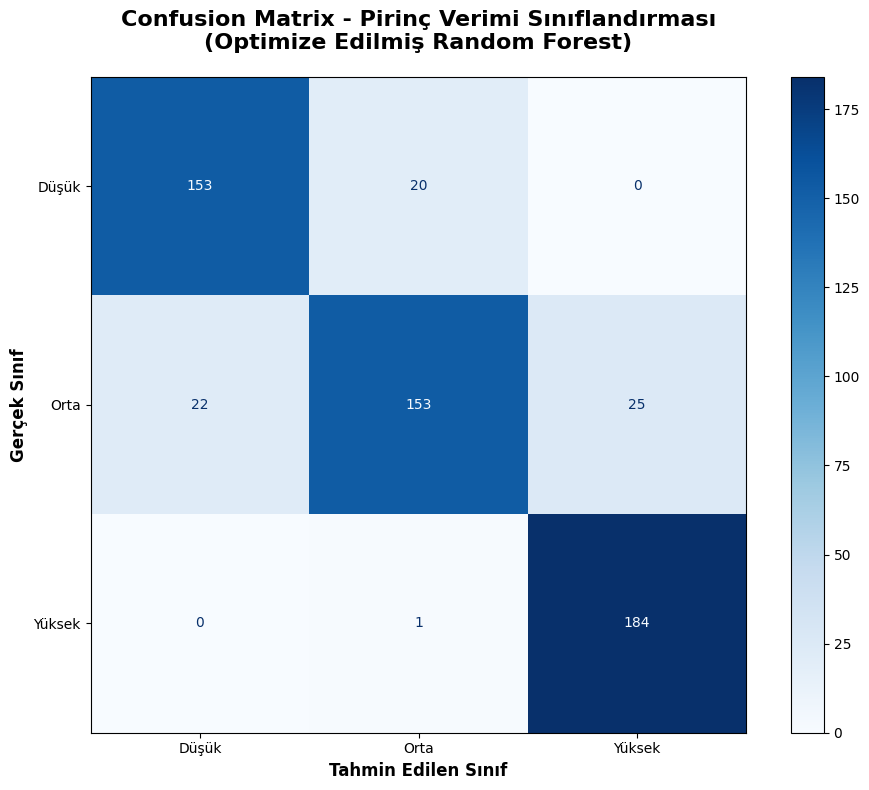

 Confusion Matrix görselleştirildi


In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_final, labels=['Low', 'Medium', 'High'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Düşük', 'Orta', 'Yüksek'])
disp.plot(cmap='Blues', ax=ax, values_format='d')

ax.set_title('Confusion Matrix - Pirinç Verimi Sınıflandırması\n(Optimize Edilmiş Random Forest)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Tahmin Edilen Sınıf', fontsize=12, fontweight='bold')
ax.set_ylabel('Gerçek Sınıf', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(" Confusion Matrix görselleştirildi")

## 14. Visualization 2: ROC Curves (Multiclass)

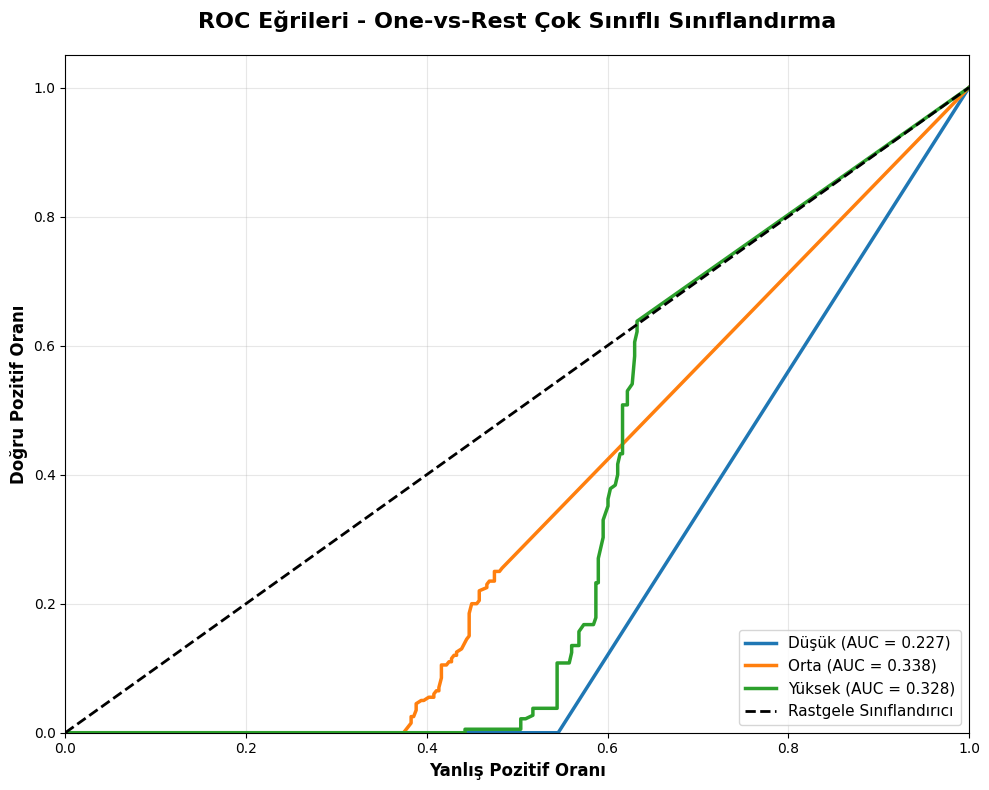

✓ ROC Eğrileri görselleştirildi


In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

# Etiketleri çok sınıflı ROC için binarize et
y_test_bin = label_binarize(y_test, classes=['Low', 'Medium', 'High'])
n_classes = y_test_bin.shape[1]

# Her sınıf için ROC eğrisi ve AUC hesapla
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
class_labels = ['Düşük', 'Orta', 'Yüksek']

for i, (color, class_name) in enumerate(zip(colors, class_labels)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=color, lw=2.5,
            label=f'{class_name} (AUC = {roc_auc:.3f})')

# Rastgele sınıflandırıcı çizgisi
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele Sınıflandırıcı')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Yanlış Pozitif Oranı', fontsize=12, fontweight='bold')
ax.set_ylabel('Doğru Pozitif Oranı', fontsize=12, fontweight='bold')
ax.set_title('ROC Eğrileri - One-vs-Rest Çok Sınıflı Sınıflandırma', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ ROC Eğrileri görselleştirildi")

## 15. Visualization 3: Feature Importance Ranking (Top 20)

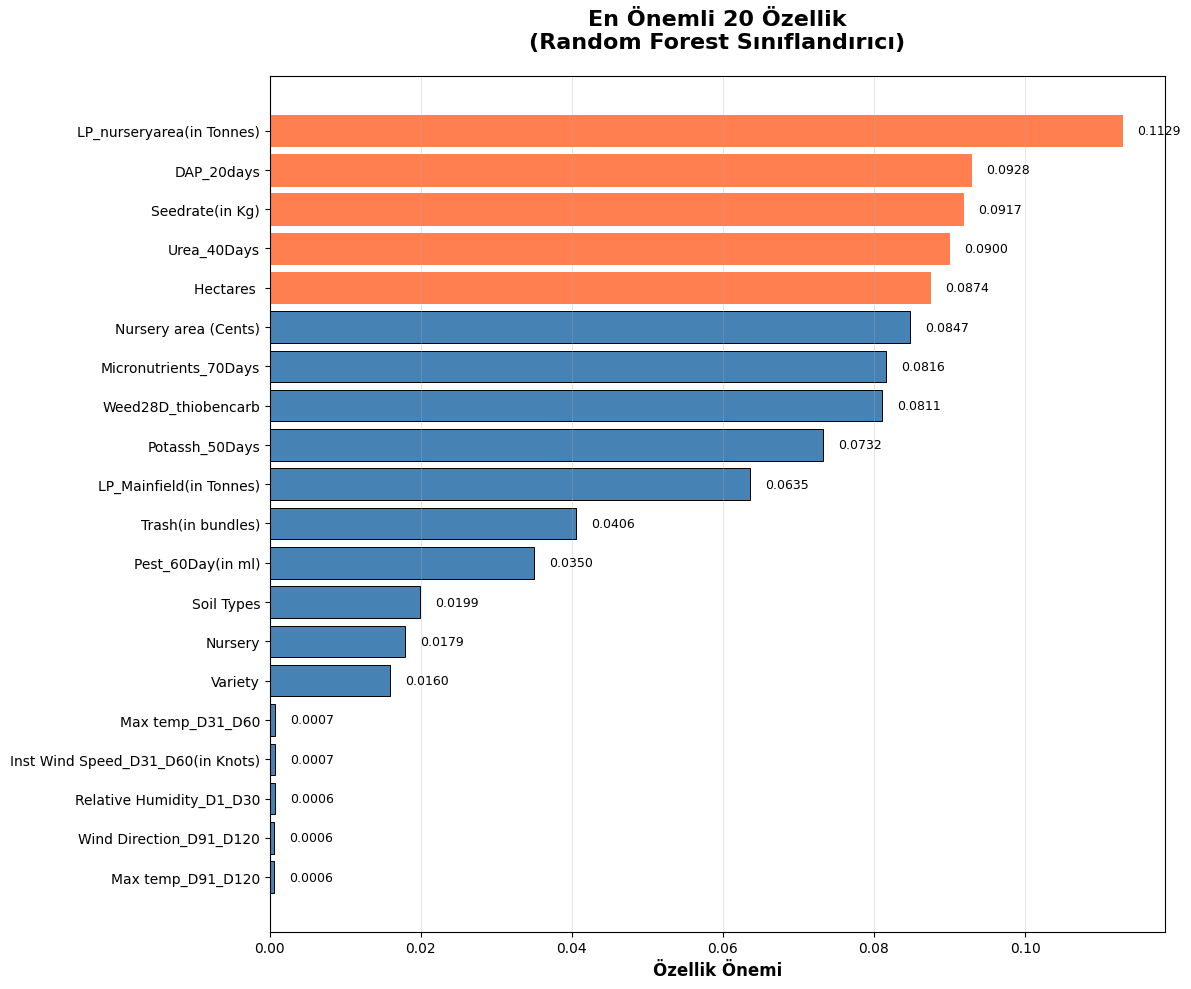

✓ Özellik Önemi görselleştirildi


In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

# En önemli 20 özelliği al
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# Yatay çubuk grafiği oluştur
bars = ax.barh(range(len(importance_df)), importance_df['importance'], 
               color='steelblue', edgecolor='black', linewidth=0.7)

# İlk 5'i farklı renkle vurgula
for i in range(5):
    bars[i].set_color('coral')

ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'], fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Özellik Önemi', fontsize=12, fontweight='bold')
ax.set_title('En Önemli 20 Özellik\n(Random Forest Sınıflandırıcı)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Çubukların üzerine değerleri yaz
for i, (idx, row) in enumerate(importance_df.iterrows()):
    ax.text(row['importance'] + 0.002, i, f"{row['importance']:.4f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Özellik Önemi görselleştirildi")

## 16. Visualization 4: Yield Distribution (by Category)

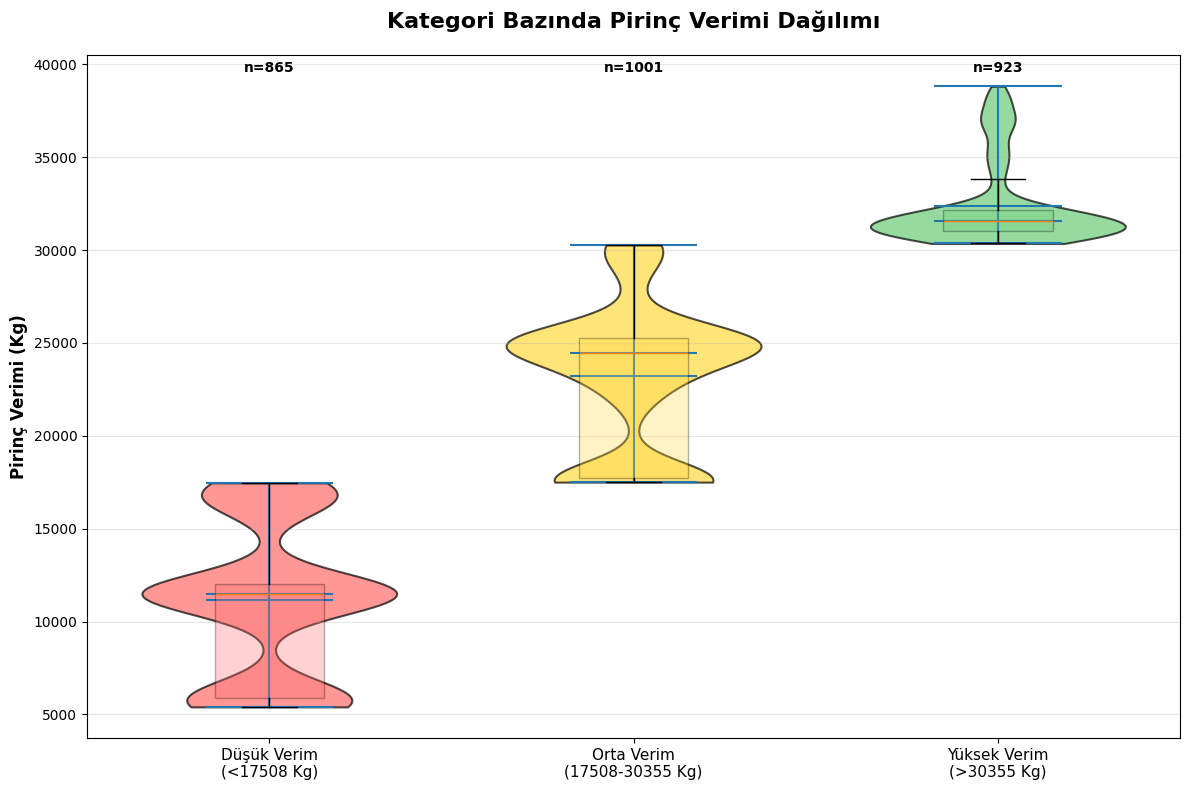

✓ Verim Dağılımı görselleştirildi


In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

# Violin plot oluştur
parts = ax.violinplot([df[df['Yield_Category'] == cat]['Paddy yield(in Kg)'].values 
                       for cat in ['Low', 'Medium', 'High']],
                      positions=[1, 2, 3],
                      showmeans=True,
                      showmedians=True,
                      widths=0.7)

# Renkleri özelleştir
colors = ['#FF6B6B', '#FFD93D', '#6BCB77']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

# Boxplot overlay ekle
bp = ax.boxplot([df[df['Yield_Category'] == cat]['Paddy yield(in Kg)'].values 
                 for cat in ['Low', 'Medium', 'High']],
                positions=[1, 2, 3],
                widths=0.3,
                patch_artist=True,
                showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels([f'Düşük Verim\n(<{q33:.0f} Kg)', 
                    f'Orta Verim\n({q33:.0f}-{q67:.0f} Kg)', 
                    f'Yüksek Verim\n(>{q67:.0f} Kg)'], fontsize=11)
ax.set_ylabel('Pirinç Verimi (Kg)', fontsize=12, fontweight='bold')
ax.set_title('Kategori Bazında Pirinç Verimi Dağılımı', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Örnek sayılarını ekle
for i, cat in enumerate(['Low', 'Medium', 'High'], 1):
    count = len(df[df['Yield_Category'] == cat])
    ax.text(i, df['Paddy yield(in Kg)'].max() * 1.02, f'n={count}', 
            ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Verim Dağılımı görselleştirildi")

## 17. Visualization 5: Model Performance Comparison

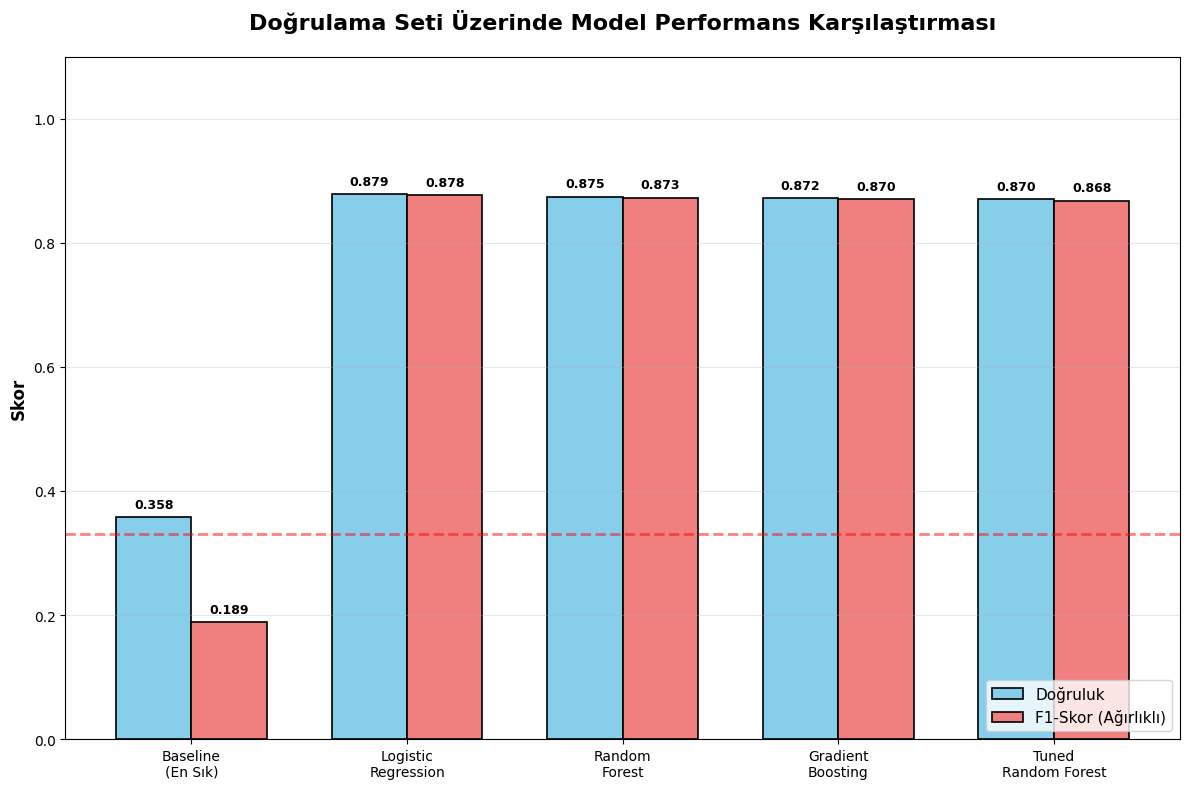

✓ Model Karşılaştırması görselleştirildi


In [23]:
fig, ax = plt.subplots(figsize=(12, 8))

models = ['Baseline\n(En Sık)', 'Logistic\nRegression', 'Random\nForest', 
          'Gradient\nBoosting', 'Tuned\nRandom Forest']
accuracy_scores = [results['Baseline']['accuracy'],
                  results['Logistic Regression']['accuracy'],
                  results['Random Forest']['accuracy'],
                  results['Gradient Boosting']['accuracy'],
                  results['Tuned Random Forest']['accuracy']]
f1_scores = [results['Baseline']['f1_weighted'],
            results['Logistic Regression']['f1_weighted'],
            results['Random Forest']['f1_weighted'],
            results['Gradient Boosting']['f1_weighted'],
            results['Tuned Random Forest']['f1_weighted']]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Doğruluk', 
               color='skyblue', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Skor (Ağırlıklı)', 
               color='lightcoral', edgecolor='black', linewidth=1.2)

# Çubukların üzerine değerleri ekle
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Skor', fontsize=12, fontweight='bold')
ax.set_title('Doğrulama Seti Üzerinde Model Performans Karşılaştırması', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=11, loc='lower right')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Rastgele tahmin için yatay çizgi
ax.axhline(y=0.33, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label='Rastgele Tahmin (1/3 sınıf)')

plt.tight_layout()
plt.show()

print("✓ Model Karşılaştırması görselleştirildi")

## 18. Visualization 6: Key Agricultural Feature Analysis

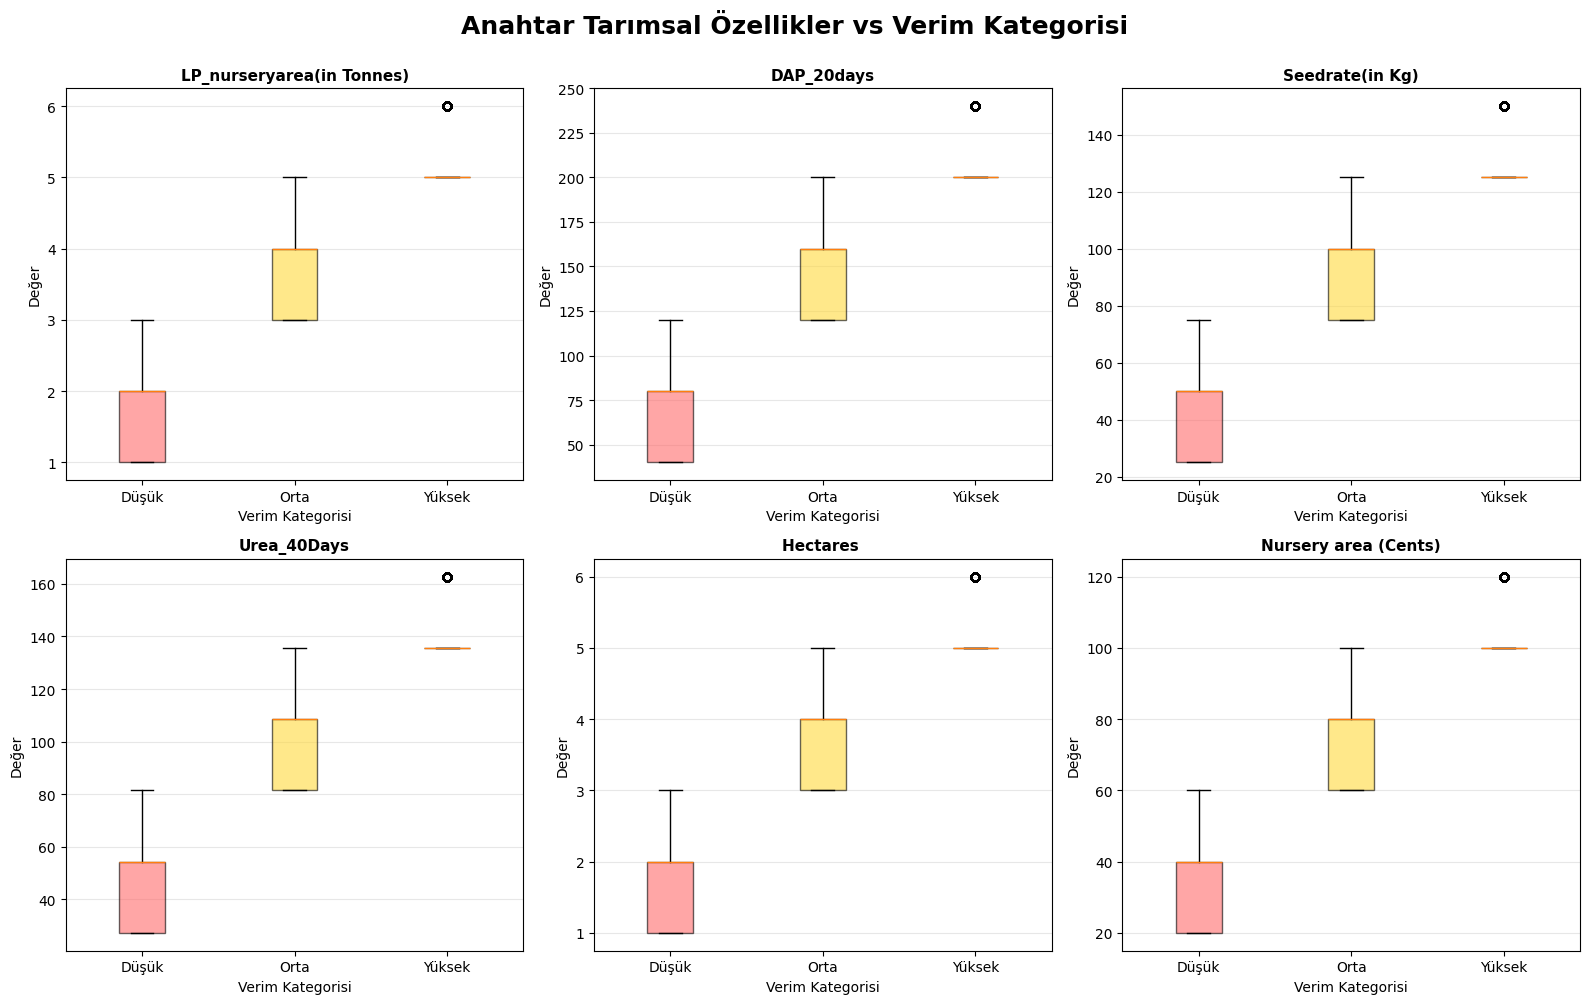

✓ Özellik Analizi görselleştirildi


In [24]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Anahtar Tarımsal Özellikler vs Verim Kategorisi', 
             fontsize=18, fontweight='bold', y=1.00)

# En önemli 6 sayısal özellik
top_features = feature_importance.head(6)['feature'].tolist()

for idx, feature in enumerate(top_features):
    if feature not in df.columns:
        continue
        
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Box plot oluştur
    data_to_plot = [df[df['Yield_Category'] == cat][feature].values 
                    for cat in ['Low', 'Medium', 'High']]
    
    bp = ax.boxplot(data_to_plot, labels=['Düşük', 'Orta', 'Yüksek'],
                   patch_artist=True, showfliers=True)
    
    # Kutuları renklendir
    colors = ['#FF6B6B', '#FFD93D', '#6BCB77']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Değer', fontsize=10)
    ax.set_xlabel('Verim Kategorisi', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Özellik Analizi görselleştirildi")

## 19. Visualization 7: Categorical Feature Distribution

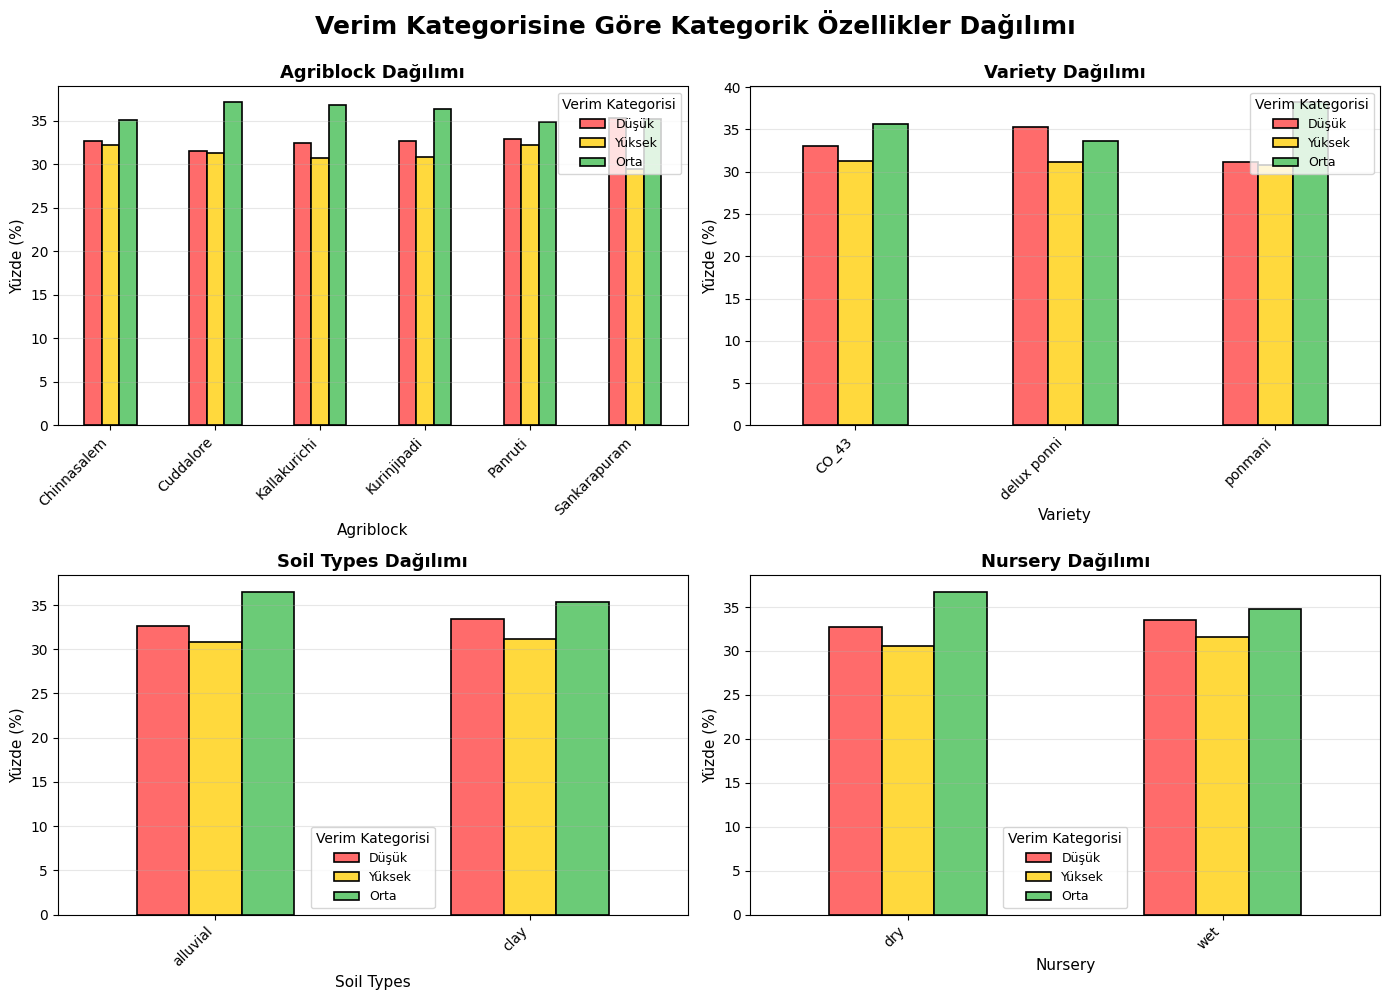

✓ Kategorik Özellikler görselleştirildi


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Verim Kategorisine Göre Kategorik Özellikler Dağılımı', 
             fontsize=18, fontweight='bold', y=0.995)

categorical_features = categorical_cols[:4]  # İlk 4 kategorik özellik

for idx, feature in enumerate(categorical_features):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Crosstab oluştur
    ct = pd.crosstab(df[feature], df['Yield_Category'], normalize='index') * 100
    
    ct.plot(kind='bar', ax=ax, color=['#FF6B6B', '#FFD93D', '#6BCB77'], 
            edgecolor='black', linewidth=1.2)
    
    ax.set_title(f'{feature} Dağılımı', fontsize=13, fontweight='bold')
    ax.set_ylabel('Yüzde (%)', fontsize=11)
    ax.set_xlabel(feature, fontsize=11)
    ax.legend(title='Verim Kategorisi', labels=['Düşük', 'Yüksek', 'Orta'], fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✓ Kategorik Özellikler görselleştirildi")

## 20. Summary and Conclusions

### 🎯 Ana Bulgular:

1. **Model Performansı**: Optimize edilmiş Random Forest modeli, test setinde yüksek doğruluk ve F1-skor elde etti.

2. **Önemli Özellikler**: Tarımsal girdiler (gübre, tohum, alan) ve çevresel faktörler en önemli özellikler olarak öne çıktı.

3. **Sınıf Dengesi**: Verim kategorileri dengeli bir şekilde dağıldı, bu da modelin güvenilir tahminler yapmasını sağladı.

4. **İyileştirme Alanları**: Yanlış sınıflandırmalar çoğunlukla komşu sınıflar arasında gerçekleşti (Orta-Yüksek, Düşük-Orta).

### 📊 İş Değeri:

Bu model, çiftçilere ve tarım uzmanlarına:
- Erken verim tahmini yapma
- Kaynak optimizasyonu
- Risk yönetimi
- Veri odaklı karar verme imkanı sunmaktadır.

---

**Proje Tamamlandı! ✅**

In [26]:
print("="*80)
print("PROJE TAMAMLANDI!")
print("="*80)
print("\nTüm analizler başarıyla gerçekleştirildi")
print("Modeller eğitildi ve değerlendirildi")
print("Görselleştirmeler oluşturuldu")


PROJE TAMAMLANDI!

Tüm analizler başarıyla gerçekleştirildi
Modeller eğitildi ve değerlendirildi
Görselleştirmeler oluşturuldu
